# Evaluate Python UDF Performance (Iris)

In [13]:
import os

import pandas as pd

import time
import json
import duckdb
from duckdb.typing import *

import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import pyarrow as pa

### Load timing data

In [14]:
times = {}
workload = 1000

In [15]:
table_name = 'imdb'
times['dataset'] = 'imdb'
times['pipeline'] = 'python_udf_vec'
times['workload'] = workload

In [16]:
con = duckdb.connect("../test.db")

In [17]:
def load_distrilbert():
    model_path = "/homes/ukumaras/scratch/Models/distilbert-base-uncased-finetuned-sst-2-english"
    load_distrilbert.tokenizer = AutoTokenizer.from_pretrained(model_path)
    load_distrilbert.model = AutoModelForSequenceClassification.from_pretrained(model_path)
    return True

In [18]:
load_distrilbert.model = None

st = time.perf_counter_ns()

con.create_function("load_distrilbert", load_distrilbert, [], BOOLEAN, side_effects=True)
res = con.sql("SELECT load_distrilbert()").show()

et = time.perf_counter_ns()

┌────────────────────┐
│ load_distrilbert() │
│      boolean       │
├────────────────────┤
│ true               │
└────────────────────┘



### Predict

In [19]:
def predict_imdb(a):
    a = a.to_numpy()[:, None]
    
    print(type(a))
    a = a.flatten().tolist()
    inputs = load_distrilbert.tokenizer(a, return_tensors="pt", max_length=512, padding=True, truncation=True)
    
    with torch.no_grad():
        logits = load_distrilbert.model(**inputs).logits

    predicted_class_id = logits.argmax(dim=1).numpy()
    print(predicted_class_id)
    
    return pa.array(predicted_class_id)

In [20]:
con.sql("PRAGMA enable_profiling='json'")
con.create_function("predict_imdb", predict_imdb, [VARCHAR], FLOAT, side_effects=True, type='arrow')
res = con.sql(f"EXPLAIN ANALYZE SELECT *, predict_imdb(text) FROM imdb LIMIT 1000").fetchall()

con.close()

<class 'numpy.ndarray'>
[1 0 0 ... 0 0 0]


In [21]:
prediction = json.loads(res[0][1])['children'][0]['children'][0]['children'][0]['children'][0]
times["predict"] = prediction['timing'] * 1000000

move = prediction['children'][0]
times["move"] = move['timing'] * 1000000

### Write to times table

In [22]:
times['load'] = (et - st)/1000
times_df = pd.DataFrame.from_records([times]).loc[:, ['dataset', 'pipeline', 'workload', 'move', 'load', 'predict']]
times_df

,dataset,pipeline,workload,move,load,predict
0,imdb,python_udf_vec,1000,57272.0,2516046.093,176626405.0


In [23]:
con = duckdb.connect("../test.db")
tables = con.sql(f"SHOW TABLES").df()
has_table = tables[tables.name == 'times'].shape[0] == 1
    
if not has_table:
    con.sql(f"CREATE TABLE times (dataset varchar, workload integer, move integer, load integer, predict integer, ts timestamp DEFAULT current_timestamp)")

con.sql(f"DELETE FROM times WHERE pipeline LIKE 'opt%'")
con.sql(f"INSERT INTO times (dataset, pipeline, workload, move, load, predict) SELECT * FROM times_df")
con.sql(f"SELECT * FROM times").show()
con.close()

┌─────────┬────────────────┬──────────┬──────────┬─────────┬───────────┬─────────────────────────┐
│ dataset │    pipeline    │ workload │   move   │  load   │  predict  │           ts            │
│ varchar │    varchar     │  int32   │  int32   │  int32  │   int32   │        timestamp        │
├─────────┼────────────────┼──────────┼──────────┼─────────┼───────────┼─────────────────────────┤
│ iris    │ python_udf_vec │  1000000 │   218034 │   13971 │   2139728 │ 2024-05-21 14:43:26.063 │
│ iris    │ python_udf_vec │  5000000 │  1185950 │   14044 │   5536022 │ 2024-05-21 14:43:54.855 │
│ iris    │ python_udf_vec │ 10000000 │  2224030 │   13889 │   7646142 │ 2024-05-21 14:49:48.529 │
│ iris    │ python_udf_vec │ 15000000 │  3188160 │   13680 │  11789199 │ 2024-05-21 14:50:06.5   │
│ iris    │ python_udf_vec │ 20000000 │  4314927 │   15031 │  14350052 │ 2024-05-21 14:50:28.176 │
│ iris    │ python_udf_vec │  1000000 │   223791 │   14497 │   1715185 │ 2024-05-21 14:50:33.186 │
│ iris    

In [24]:
con.close()

In [43]:
con = duckdb.connect("../test.db")
    
out = con.sql(f"SELECT * FROM times WHERE dataset == 'imdb' AND workload == 1000").df()
con.close()

In [46]:
results = pd.DataFrame(out).drop(columns=['dataset', 'ts', 'workload'])
results = pd.concat([results, pd.DataFrame([{'pipeline': 'opt_vec (ours)', 'load': 799463, 'move': 2322044, 'predict': 117655647}])])
results

,pipeline,move,load,predict
0,python_udf_vec,57272,2516046,176626405
1,traditonal,718027,3641943,87026763
0,opt_vec (ours),2322044,799463,117655647


<Axes: xlabel='pipeline', ylabel='time'>

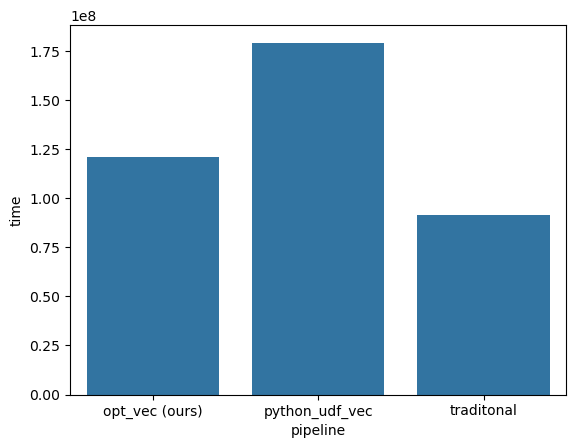

In [47]:
final = results.melt(id_vars='pipeline', value_name='time', var_name='stage').groupby('pipeline').sum().reset_index().drop(columns=['stage'])
import seaborn as sns

sns.barplot(y='time', x='pipeline', data=final)